# Model Training & Evaluation Pipeline

Details: [Model Training Specifications](https://docs.google.com/document/d/1UiDi8nyTcfMeMNIAz3KntlVZBlYrpoMAURuDccTt-wk/edit?usp=sharing)

Model Evaluation: Identify best parameters for each model

In [ ]:
# Basic Libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Source

df = pd.read_csv("/content/drive/MyDrive/cleaned_gee_data_v3.csv")
df = df.drop(columns = ['Unnamed: 0'], axis=1) # Drop index
df = df.drop(columns = ['LATITUDE', 'LONGITUDE'], axis=1)
df.head() 

,CO_MOL/M2,SO2_MOL/M2,NO2_MOL/M2,O3_MOL/M2,FIRE_OCCURRED
0,0.252793,0.175102,0.048868,0.390066,0
1,0.267145,0.175102,0.048868,0.390066,0
2,0.252793,0.175102,0.041340,0.390066,0
3,0.267145,0.175102,0.041340,0.390066,0
4,0.154547,0.210118,0.045284,0.550787,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171893 entries, 0 to 171892
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CO_MOL/M2      171893 non-null  float64
 1   SO2_MOL/M2     171893 non-null  float64
 2   NO2_MOL/M2     171893 non-null  float64
 3   O3_MOL/M2      171893 non-null  float64
 4   FIRE_OCCURRED  171893 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 6.6 MB


In [ ]:
display(df['FIRE_OCCURRED'].value_counts())

0    170544
1      1349
Name: FIRE_OCCURRED, dtype: int64

0.785% of FIRE_OCCURRED = 1

In [ ]:
X = df.drop('FIRE_OCCURRED', axis=1)
y = df['FIRE_OCCURRED']

In [ ]:
# Training, Validation, Testing Split

from sklearn.model_selection import train_test_split

# 80:10:10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=10, shuffle=True)

Original = [X_train, X_val, X_test, y_train, y_val, y_test] # For reference

In [ ]:
if len(X_train)==len(y_train) and len(X_test) == len(y_test) and len(X_val) == len(y_val):
  print("X and y data length matching")
else:
  print("Error in data preparation pipeline")
print()
print("No. of training data = %d" % len(X_train))
print("No. of validation data = %d" % len(X_val))
print("No. of testing data = %d" % len(X_test))

X and y data length matching

No. of training data = 137513
No. of validation data = 17190
No. of testing data = 17190


In [ ]:
display(y_val.value_counts())

0    17068
1      122
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
display(y_test.value_counts())

0    17059
1      131
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# SMOTE

from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 136417, 1: 1096})
Resampled dataset shape Counter({0: 136417, 1: 136417})


In [ ]:
# Shuffle Data since SMOTE appended many 1s at the end
# Required for some algorithms such as ANN

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state = 10)

In [ ]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score

def evaluation_metrics(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred).ravel()
  acc = accuracy_score(y_true, y_pred)
  recs = recall_score(y_true, y_pred, average='binary')
  f1s = f1_score(y_true, y_pred, average='binary')
  rocs = roc_auc_score(y_true, y_pred, average='macro')
  return [cfm, acc, recs, f1s, rocs]

Confusion matrix format : [ tn , fp , fn , tp ]

In [ ]:
# Store Model Parameters and Eval

models = pd.DataFrame(columns = ['model_name', 'model', 'parameters'])
models_eval = pd.DataFrame(columns = ['model_name', 'confusion_matrix', 'accuracy', 'recall', 'f1_score', 'roc_auc_score'])

In [ ]:
# Import ML Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import VotingClassifier

# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

## Logistic Regression

- Library: Scikit-learn

In [ ]:
# Training

name = 'log_clf'

train = pd.DataFrame(columns = ['penalty', 'warm_start', 'solver', 'max_iter', 'dual', 'n_jobs','random_state'])
train = train.append({'penalty' : 'none', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 247,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'penalty' : 'l2', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 100,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    log_clf = LogisticRegression(penalty = row['penalty'], n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    log_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = log_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': log_clf, 
                            'parameters': log_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[10970, 6098, 55, 67]",0.642059,0.549180,0.021314,0.595952
1,log_clf1,"[10973, 6095, 56, 66]",0.642176,0.540984,0.021009,0.591941


In [ ]:
[np.arange(0, 1.1, 0.1)]

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]

In [ ]:
# RandomizedSearchCV

random_grid = {
                "penalty": ['l1', 'l2', 'elasticnet', 'none'],
                "max_iter" :[100, 200, 300, 400, 500],
                "warm_start" : [True, False],
                "solver" : ['lbfgs', 'newton-cg', 'liblinear'],
                "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 1.0]
              }

log_random = RandomizedSearchCV(estimator = log_clf, 
                                param_distributions = random_grid, 
                                n_iter = 70, 
                                cv = 3, 
                                verbose = 3, 
                                scoring = 'recall',
                                random_state = 10)

log_random.fit(X_train, y_train)
log_random.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV 1/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.1s
[CV 2/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.2, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.592 total time=   6.2s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.587 total time=   2.9s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.8, max_iter=400, penalty=l1, solver=liblinear, warm_start=True;, score=0.585 total time=   2.4s
[CV 1/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=400, penalty=l1, solver=newton-cg, warm_start=True;, score=nan total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.592 total time=   1.4s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.588 total time=   1.4s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.4, max_iter=300, penalty=none, solver=lbfgs, warm_start=True;, score=0.585 total time=   1.6s
[CV 1/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.590 total time=   1.6s
[CV 2/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.587 total time=   1.6s
[CV 3/3] END C=0.7, max_iter=100, penalty=l2, solver=lbfgs, warm_start=True;, score=0.584 total time=   1.5s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 1/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.591 total time=   2.3s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 2/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.587 total time=   2.3s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV 3/3] END C=0.5, max_iter=200, penalty=l1, solver=liblinear, warm_start=True;, score=0.585 total time=   2.2s
[CV 1/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 3/3] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.592 total time=   1.4s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.588 total time=   1.5s


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/3] END C=0.1, max_iter=300, penalty=none, solver=lbfgs, warm_start=False;, score=0.585 total time=   2.2s
[CV 1/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.5, max_iter=500, penalty=none, solver=liblinear, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 2/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 3/3] END C=0.8, max_iter=100, penalty=l1, solver=lbfgs, warm_start=True;, score=nan total time=   0.0s
[CV 1/3] END C=0.1, max_iter=400, penalty=elasticnet, solver=newton-cg, warm_start=False;, score=nan total time=   0.0s
[CV 2/3] END C=0.1, max_iter=400, penalty=elasticnet, solver=newton-cg, warm_start=False;, score=nan total t

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


KeyboardInterrupt: ignored

Errors expected because there are different supported penalties for different solvers. Increase RandomizedSearchCV iterations to compensate.

* ‘lbfgs’ - [‘l2’, None]
* ‘liblinear’ - [‘l1’, ‘l2’]
* ‘newton-cg’ - [‘l2’, None]



In [ ]:
log_random.best_params_

In [ ]:
log_random.best_score_

## Support Vector Machine (SVM)

- Library: Scikit-learn

Approach 1: Undersampling to lower number of training samples and reduce learning time

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
display(y_train_SVM.value_counts())

In [ ]:
# Undersampling & Shuffle

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10)
X_train_SVM, y_train_SVM = rus.fit_resample(X_train_SVM, y_train_SVM)
X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'poly', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'sigmoid', 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    print("Currently at :" , model_name)
    svc_clf = SVC(kernel=row["kernel"], random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

The best kernel is rbf for recall score. All kernel gives poor F1-score

Approach 2: Class-weighted SVM with original amount of data (before SMOTE)

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
# Shuffle

X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'C': 1, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 2, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 4, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 8, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    index = index + 3
    model_name = name + str(index)
    print("Current at ", model_name)
    svc_clf = SVC(kernel = row["kernel"], class_weight='balanced', C = int(row["C"]), random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models)

In [ ]:
display(models_eval)

Best Parameters: 

{'kernel': 'rbf', 'C' : '8', 'class_weight'='balanced'}

## Naive Bayes

- Library: Scikit-learn

In [ ]:
# Training

name = 'bayes_clf'

train = pd.DataFrame(columns = ['var_smoothing'])
train = train.append({'var_smoothing': 1e-0}, ignore_index=True)
train = train.append({'var_smoothing': 1e-1}, ignore_index=True)
train = train.append({'var_smoothing': 1e-3}, ignore_index=True)
train = train.append({'var_smoothing': 1e-5}, ignore_index=True)
train = train.append({'var_smoothing': 1e-9}, ignore_index=True)
train = train.append({'var_smoothing': 1e-10}, ignore_index=True)
train = train.append({'var_smoothing': 1e-20}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    bayes_clf = GaussianNB(var_smoothing = row['var_smoothing'])
    bayes_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = bayes_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': bayes_clf, 
                            'parameters': bayes_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

Best Parameters: 

{'var_smoothing': '1e-3'}

## K-Nearest Neighbor

- Library: Scikit-learn
- Shuffling does not affect the model building. No random_state.

In [ ]:
# Training

name = 'neigh_clf'

train = pd.DataFrame(columns = ['n_neighbors', 'algorithm', 'n_jobs'])
train = train.append({'n_neighbors': 5, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 1, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 20, 'algorithm':'kd_tree', 'n_jobs':-1}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    neigh_clf = KNeighborsClassifier(n_neighbors=int(row['n_neighbors']), algorithm = row['algorithm'], n_jobs = int(row['n_jobs']))
    neigh_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = neigh_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': neigh_clf, 
                            'parameters': neigh_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

random_grid = {
                "n_neighbors": [int(x) for x in np.linspace(1, 20, num = 20)],
                "algorithm": ['auto', 'kd_tree','ball_tree']
              }

neigh_random = RandomizedSearchCV(estimator = neigh_clf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose = 3, 
                                  scoring = 'recall',
                                  random_state = 10)

neigh_random.fit(X_train, y_train)
neigh_random.best_params_

In [ ]:
neigh_random.best_params_

In [ ]:
neigh_random.best_score_

## Decision Tree

- Library: Scikit-learn

In [ ]:
# Training

name = 'tree_clf'

train = pd.DataFrame(columns = ['criterion', 'splitter', 'min_samples_leaf', 'max_features', 'max_depth', 'n_jobs', 'random_state'])
train = train.append({'criterion' : 'gini', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'gini', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    tree_clf = DecisionTreeClassifier(criterion = row['criterion'], splitter = row['splitter'], max_depth = None, random_state = row['random_state'])
    tree_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = tree_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': tree_clf, 
                            'parameters': tree_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

max_depth = [1, 3, 5, 8, 10, 15]
max_depth.append(None)

random_grid = {
              "max_depth": max_depth,
              "max_features": [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))],
              "min_samples_leaf": [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))],
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["random", "best"]
              }

tree_random = RandomizedSearchCV(estimator = tree_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 100, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

tree_random.fit(X_train, y_train)
tree_random.best_params_

In [ ]:
tree_random.best_params_

In [ ]:
tree_random.best_score_

## Random Forest Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'rnd_clf'

train = pd.DataFrame(columns = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features','max_depth', 'n_jobs', 'random_state'])
train = train.append({'n_estimators' : 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : 31, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    rnd_clf = RandomForestClassifier(n_estimators = int(row['n_estimators']), max_depth = None, 
                                    n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    rnd_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = rnd_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': rnd_clf, 
                            'parameters': rnd_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators = [100, 200, 300, 400, 500]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, len(X_train.columns), num = len(X_train.columns))]
# Maximum number of levels in tree
max_depth = [1, 3, 5, 8, 10, 15]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 6, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

rnd_random = RandomizedSearchCV(estimator = rnd_clf, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose = 3, 
                                scoring = 'recall',
                                random_state = 10)

rnd_random.fit(X_train, y_train)
rnd_random.best_params_

In [ ]:
rnd_random.best_params_

In [ ]:
rnd_random.best_score_

## Gradient Boosting Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'gboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 100, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 50, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    gboost_clf = GradientBoostingClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                            max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    gboost_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = gboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': gboost_clf, 
                            'parameters': gboost_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15]
              }

gboost_random = RandomizedSearchCV(estimator = gboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 15, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

gboost_random.fit(X_train, y_train)
gboost_random.best_params_

In [ ]:
gboost_random.best_params_

In [ ]:
gboost_random.best_score_

## XGBoost

- Library: xgboost

In [ ]:
# Training

name = 'xgboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':8, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    xgboost_clf = XGBClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    xgboost_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = xgboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': xgboost_clf, 
                            'parameters': xgboost_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,xgboost_clf0,"[16569, 499, 47, 75]",0.968237,0.614754,0.215517,0.792759
1,xgboost_clf1,"[13740, 3328, 28, 94]",0.804770,0.770492,0.053047,0.787754
2,xgboost_clf2,"[16184, 884, 23, 99]",0.947237,0.811475,0.179186,0.879841


In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15],
              "min_child_weight" : [1, 3, 5, 7]
              }

xgboost_random = RandomizedSearchCV(estimator = xgboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

xgboost_random.fit(X_train, y_train)
xgboost_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=100;, score=0.991 total time=  41.6s
[CV 2/3] END learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=100;, score=0.991 total time=  42.1s
[CV 3/3] END learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=100;, score=0.992 total time=  42.2s
[CV 1/3] END learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=100;, score=0.924 total time=  14.0s
[CV 2/3] END learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=100;, score=0.922 total time=  14.2s
[CV 3/3] END learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=100;, score=0.921 total time=  14.1s
[CV 1/3] END learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=100;, score=0.984 total time=  31.6s
[CV 2/3] END learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=100;, score=0.982 total time=  28.6s
[CV 3/3] E

{'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.2}

In [ ]:
xgboost_random.best_params_

{'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.2}

In [ ]:
xgboost_random.best_score_

0.9929774146226307

## LightGBM

- Library: lightbgm

In [ ]:
# Training

name = 'lightgbm_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    lightgbm_clf = LGBMClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    lightgbm_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = lightgbm_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)   

    models = models.append({'model_name': model_name, 
                            'model': lightgbm_clf, 
                            'parameters': lightgbm_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,xgboost_clf0,"[16569, 499, 47, 75]",0.968237,0.614754,0.215517,0.792759
1,xgboost_clf1,"[13740, 3328, 28, 94]",0.804770,0.770492,0.053047,0.787754
2,xgboost_clf2,"[16184, 884, 23, 99]",0.947237,0.811475,0.179186,0.879841
3,lightgbm_clf0,"[15652, 1416, 20, 102]",0.916463,0.836066,0.124390,0.876552
4,lightgbm_clf1,"[13541, 3527, 31, 91]",0.793019,0.745902,0.048663,0.769629
5,lightgbm_clf2,"[15476, 1592, 20, 102]",0.906225,0.836066,0.112335,0.871396


In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15, 20],
              "num_leaves": [10, 31, 50, 100, 200, 500],
              "min_data_in_leaf": [10, 20, 25, 50, 100]
              }

lightgbm_random = RandomizedSearchCV(estimator = lightgbm_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 5, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

lightgbm_random.fit(X_train, y_train)
lightgbm_random.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END learning_rate=0.05, max_depth=8, min_data_in_leaf=50, n_estimators=750, num_leaves=500;, score=0.986 total time=  23.8s
[CV 2/5] END learning_rate=0.05, max_depth=8, min_data_in_leaf=50, n_estimators=750, num_leaves=500;, score=0.987 total time=  21.5s
[CV 3/5] END learning_rate=0.05, max_depth=8, min_data_in_leaf=50, n_estimators=750, num_leaves=500;, score=0.986 total time=  22.1s
[CV 4/5] END learning_rate=0.05, max_depth=8, min_data_in_leaf=50, n_estimators=750, num_leaves=500;, score=0.989 total time=  22.3s
[CV 5/5] END learning_rate=0.05, max_depth=8, min_data_in_leaf=50, n_estimators=750, num_leaves=500;, score=0.987 total time=  21.2s
[CV 1/5] END learning_rate=0.25, max_depth=8, min_data_in_leaf=25, n_estimators=750, num_leaves=100;, score=0.994 total time=  18.8s
[CV 2/5] END learning_rate=0.25, max_depth=8, min_data_in_leaf=25, n_estimators=750, num_leaves=100;, score=0.992 total time=  20.5s
[CV 3/5

{'num_leaves': 200,
 'n_estimators': 100,
 'min_data_in_leaf': 20,
 'max_depth': 20,
 'learning_rate': 0.3}

In [ ]:
lightgbm_random.best_params_

{'num_leaves': 200,
 'n_estimators': 100,
 'min_data_in_leaf': 20,
 'max_depth': 20,
 'learning_rate': 0.3}

In [ ]:
lightgbm_random.best_score_

0.9936958033301959

## Artificial Neural Network

- Library: Keras, Tensorflow

In [ ]:
tf.random.set_seed(10)

print(tf.__version__)
print(keras.__version__)

2.11.0
2.11.0


#### Experiment 1: Base Model

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272834 entries, 32349 to 236669
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CO_MOL/M2   272834 non-null  float64
 1   SO2_MOL/M2  272834 non-null  float64
 2   NO2_MOL/M2  272834 non-null  float64
 3   O3_MOL/M2   272834 non-null  float64
dtypes: float64(4)
memory usage: 10.4 MB


In [ ]:
ann_clf = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
    # keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

ann_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                75        
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 246
Trainable params: 246
Non-trainable params: 0
_________________________________________________________________


In [ ]:
display(y_train.value_counts())

0    136417
1    136417
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
display(y_val.value_counts())

0    17068
1      122
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')

# ann_clf.compile(optimizer = 'adam', 
#                 loss ='binary_crossentropy',
#                 metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

record = ann_clf.fit(
            X_train, 
            y_train, 
            validation_data = (X_val, y_val), 
            batch_size = 10, 
            epochs = 50)

Epoch 1/50
27284/27284 [==============================] - 71s 3ms/step - loss: 0.6125 - accuracy: 0.6586 - val_loss: 0.6766 - val_accuracy: 0.5674
Epoch 2/50
27284/27284 [==============================] - 66s 2ms/step - loss: 0.5659 - accuracy: 0.7129 - val_loss: 0.4610 - val_accuracy: 0.7490
Epoch 3/50
27284/27284 [==============================] - 67s 2ms/step - loss: 0.5444 - accuracy: 0.7252 - val_loss: 0.6150 - val_accuracy: 0.6330
Epoch 4/50
27284/27284 [==============================] - 66s 2ms/step - loss: 0.5295 - accuracy: 0.7363 - val_loss: 0.5633 - val_accuracy: 0.6631
Epoch 5/50
27284/27284 [==============================] - 64s 2ms/step - loss: 0.5203 - accuracy: 0.7426 - val_loss: 0.4556 - val_accuracy: 0.7644
Epoch 6/50
27284/27284 [==============================] - 65s 2ms/step - loss: 0.5127 - accuracy: 0.7471 - val_loss: 0.4144 - val_accuracy: 0.7847
Epoch 7/50
27284/27284 [==============================] - 66s 2ms/step - loss: 0.5069 - accuracy: 0.7506 - val_loss: 0

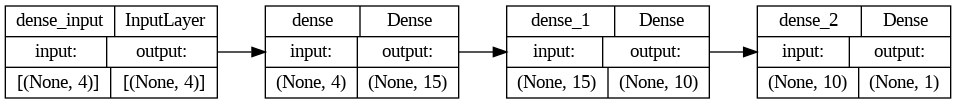

In [ ]:
keras.utils.plot_model(ann_clf, show_shapes=True, rankdir="LR")

In [ ]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

Train: 0.790, Validation: 0.782, Test: 0.772


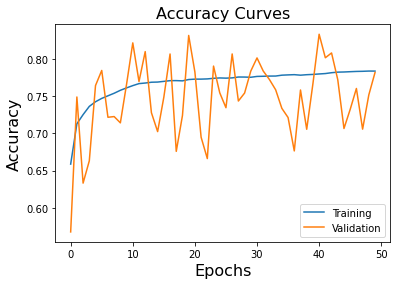

In [ ]:
plt.plot(record.history['accuracy'], label='Training')
plt.plot(record.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

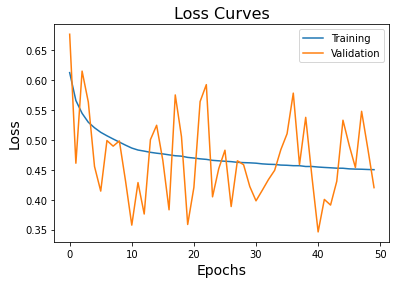

In [ ]:
# plot training history
plt.plot(record.history['loss'], label='Training')
plt.plot(record.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

#### Experiment 2: Different Batch Sizes

In [ ]:
# Fit a Model and Plot Learning Curve

def fit_model_1(X_train, y_train, X_val, y_val, n_batch):
  
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

  
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=100,
                      verbose=0,
                      batch_size=n_batch)

  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train') 
  plt.plot(history.history['val_accuracy'], label='test') 
  plt.title('batch='+str(n_batch)) 
  plt.legend()

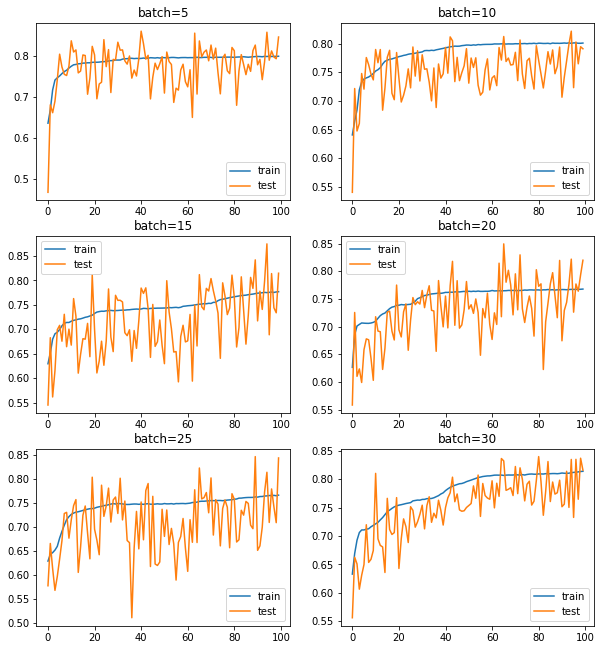

In [ ]:
# Create Learning Curves for Different Batch Sizes

# batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
batch_sizes = [5, 10, 15, 20, 25, 30]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for a Batch Size
  fit_model_1(X_train, y_train, X_val, y_val, batch_sizes[i])

plt.show()

Based on the accuracy graph above, the model that is good enough to show stability is the model with batch size 30

#### Experiment 3: Different EPOCHs

In [ ]:
# Fit a Model and Plot Learning Curve

def fit_model_2(X_train, y_train, X_val, y_val, n_epoch):

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

    
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=n_epoch,
                      verbose=0,
                      batch_size=15)
    
  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('epoch='+str(n_epoch))
  plt.legend()

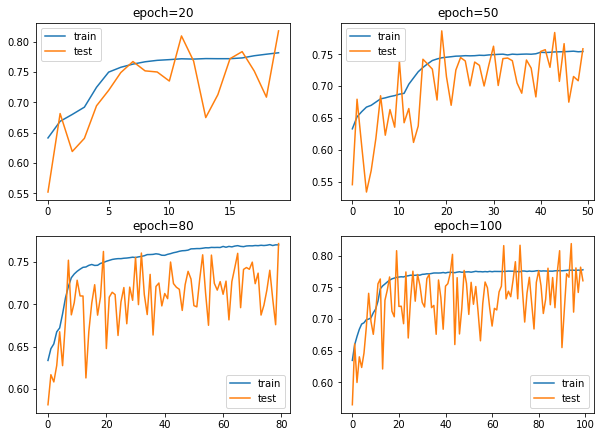

In [ ]:
# Create Learning Curves for Different EPOCHs

epochs = [20, 50, 80, 100]

plt.figure(figsize=(10,15))
for i in range(len(epochs)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for an EPOCH
  fit_model_2(X_train, y_train, X_val, y_val, epochs[i])

plt.show()

Based on the accuracy graph above, the model that is good enough to show stability is the model with EPCOH 50

#### Experiment 4: Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
def fit_model_3():

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      # keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                  metrics=['accuracy'],
                  loss = 'binary_crossentropy')

  return ann_clf

ann_clf = fit_model_3()

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=150)

mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

history = ann_clf.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=0,
                    batch_size=15,
                    callbacks=[es, mc])


Epoch 1: val_accuracy improved from -inf to 0.51507, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.51507 to 0.62065, saving model to best_model.h5

Epoch 3: val_accuracy did not improve from 0.62065

Epoch 4: val_accuracy improved from 0.62065 to 0.69343, saving model to best_model.h5

Epoch 5: val_accuracy improved from 0.69343 to 0.73269, saving model to best_model.h5

Epoch 6: val_accuracy did not improve from 0.73269

Epoch 7: val_accuracy did not improve from 0.73269

Epoch 8: val_accuracy improved from 0.73269 to 0.75026, saving model to best_model.h5

Epoch 9: val_accuracy did not improve from 0.75026

Epoch 10: val_accuracy did not improve from 0.75026

Epoch 11: val_accuracy did not improve from 0.75026

Epoch 12: val_accuracy did not improve from 0.75026

Epoch 13: val_accuracy improved from 0.75026 to 0.76050, saving model to best_model.h5

Epoch 14: val_accuracy did not improve from 0.76050

Epoch 15: val_accuracy did not improve from 0.76050

Epoch 

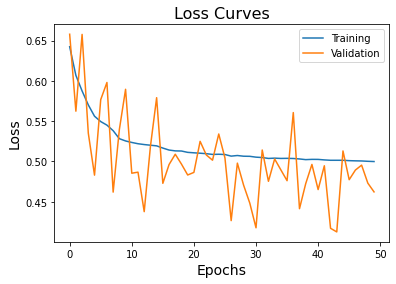

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

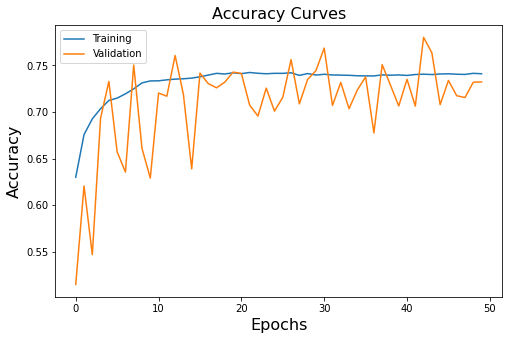

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

In [ ]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

Train: 0.772, Validation: 0.732, Test: 0.722


Accuracy result for no early stopping  - Train: 0.964, Validation: 0.946, Test: 0.945

Accuracy result for early stopping - Train: 0.961, Validation: 0.935, Test: 0.931

Early stopping is not beneficial

## Voting Classifier

- Library: Scikit-learn, Keras, Tensorflow
- Shuffling does not affect the model building. No random_state.
- No need for RandomizedSearchCV since there is only 1 important hyperparameter: voting

In [ ]:
# Re-train top 3 models using their best hyperparameters

model_1 = LGBMClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=10)
model_2 = XGBClassifier(n_estimators=1000, min_child_weight=5, max_depth=10, learning_rate=0.25)
model_3 = KNeighborsClassifier(n_neighbors=7, algorithm='ball_tree')

name = 'ensem_clf'

train = pd.DataFrame(columns = ['voting', 'n_jobs'])
train = train.append({'voting': 'hard', 'n_jobs': -1}, ignore_index=True)
train = train.append({'voting': 'soft', 'n_jobs': -1}, ignore_index=True)
train = train.reset_index()

for index, row in train.iterrows():
    model_name = name + str(index)
    ens_clf = VotingClassifier(estimators=[('m1', model_1), ('m2', model_2), ('m3', model_3)],
                               voting = row['voting'],
                               n_jobs = int(row['n_jobs']))
    ens_clf.fit(X_train, y_train)
    y_true = y_val
    y_pred = ens_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': ens_clf, 
                            'parameters': ens_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,xgboost_clf0,"[16569, 499, 47, 75]",0.968237,0.614754,0.215517,0.792759
1,xgboost_clf1,"[13740, 3328, 28, 94]",0.804770,0.770492,0.053047,0.787754
2,xgboost_clf2,"[16184, 884, 23, 99]",0.947237,0.811475,0.179186,0.879841
3,lightgbm_clf0,"[15652, 1416, 20, 102]",0.916463,0.836066,0.124390,0.876552
4,lightgbm_clf1,"[13541, 3527, 31, 91]",0.793019,0.745902,0.048663,0.769629
5,lightgbm_clf2,"[15476, 1592, 20, 102]",0.906225,0.836066,0.112335,0.871396
6,ensem_clf0,"[16555, 513, 47, 75]",0.967423,0.614754,0.211268,0.792349
7,ensem_clf1,"[16552, 516, 47, 75]",0.967248,0.614754,0.210379,0.792261


Best Parameters: 

{'voting': 'hard'}